<a href="https://colab.research.google.com/github/pskshyam/FaceDetection_OpenCV_DNN/blob/master/FaceDetection_OpenCV_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Background
You may already know that OpenCV ships out-of-the-box with pre-trained Haar cascades that can be used for face detection…but you may not be knowing about the **“hidden” deep learning-based face detector** that has been part of OpenCV since OpenCV 3.3.

Back in August 2017, OpenCV 3.3 was officially released, bringing it with a highly improved “deep neural networks” ( dnn ) module. This module supports a number of deep learning frameworks, including Caffe, TensorFlow, and Torch/PyTorch.

### Contents
* How it works
* Finding “hidden” deep learning face detector in the OpenCV library
* Steps involved in face detection
* Performing face detection in images using OpenCV and deep learning
* Performing face detection in video using OpenCV and deep learning

### How it works
OpenCV’s deep learning face detector is based on the Single Shot Detector (SSD) framework with a ResNet base network (unlike other OpenCV SSDs that you may have seen which typically use MobileNet as the base network).

### Finding “hidden” deep learning face detector in the OpenCV library
When using OpenCV’s deep neural network module with Caffe models, you’ll need two sets of files:

* The .prototxt file(s) which define the model architecture (i.e., the layers themselves)
* The .caffemodel file which contains the weights for the actual layers

.prototxt files can be found in the [GitHub repo](https://github.com/opencv/opencv/tree/master/samples/dnn/face_detector). The weight files are not included in the OpenCV samples directory and it requires a bit more digging to find them…

### Steps involved in face detection

* Load the model
* Read the image and create a blob image
* Pass the blob through the network and get detections
* Loop over the detections, filter detections with less confidence and draw boxes around the detected faces

### Performing face detection in images using OpenCV and deep learning
In this first example we’ll learn how to apply face detection with OpenCV to single input images.

In the next section we’ll learn how to modify this code and apply face detection with OpenCV to videos, video streams, and webcams.

In [2]:
#Mount Google Drive for accessing required files
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#Change the current location to the GDrive location where files are stored
%cd '/content/gdrive/My Drive/Colab Notebooks/FaceDetection'

/content/gdrive/My Drive/Colab Notebooks/FaceDetection


In [4]:
#Check for the files
!ls -ltr deep-learning-face-detection

total 11619
-rw------- 1 root root 10666211 Jan 21  2018  res10_300x300_ssd_iter_140000.caffemodel
-rw------- 1 root root    28092 Jan 21  2018  deploy.prototxt.txt
-rw------- 1 root root     2613 Feb 20  2018  detect_faces_video.py
-rw------- 1 root root    37918 Feb 20  2018  rooster.jpg
-rw------- 1 root root    21602 Feb 20  2018  iron_chic.jpg
-rw------- 1 root root     2263 Feb 28 12:39  detect_faces.py
-rw------- 1 root root  1136801 Feb 28 14:14 'Sony FS5 Face Detection Sample.mp4'


In [0]:
# import necessary packages
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt

In [0]:
#Assign required variables
prototxt = 'deep-learning-face-detection/deploy.prototxt.txt'                    #The path to the Caffe prototxt file
model = 'deep-learning-face-detection/res10_300x300_ssd_iter_140000.caffemodel'  #The path to the pretrained Caffe model
image = 'deep-learning-face-detection/iron_chic.jpg'                             #The path to the input image 
confidence = 0.5                                                                 #Minimum probability to filter weak detections

In [0]:
# load our serialized model
net = cv2.dnn.readNetFromCaffe(prototxt, model)

In [0]:
# load the input image and construct an input blob for the image
# by resizing to a fixed 300x300 pixels and then normalizing it
image = cv2.imread(image)
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,                 #blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size, mean, swapRB=True)
	                           (300, 300), (104.0, 177.0, 123.0))

The `dnn.blobFromImage`  takes care of pre-processing which includes setting the blob  dimensions and normalization. For learning more about the dnn.blobFromImage  function, review in detail at [BlobFromImage](https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/)

In [10]:
#Check the shape of input and blob image
print(image.shape)
print(blob.shape)

(500, 500, 3)
(1, 3, 300, 300)


The blob has 4 dimensions.

* First is number of images
* Second is number of channels
* Third and Fourth are height and width of the image

In [0]:
# pass the blob through the network and obtain the detections and predictions
net.setInput(blob)
detections = net.forward()

In [12]:
#Check the shape of detections
detections.shape

(1, 1, 107, 7)

In [13]:
#Retrieving Bounding box coordinates
detections[0, 0, 0, 3:7]

array([0.5247787 , 0.11720119, 0.86877465, 0.5470664 ], dtype=float32)

The output Detections contain 4 dimensions

Third dimension gives number of predictions

Fourth dimension, 
  - 2nd value gives confidence score 
  - 3 to 7 values give bounding box (x,y) coordinates  

In [0]:
# loop over the detections
for i in range(0, detections.shape[2]):
  # extract the confidence (i.e., probability) associated with the prediction
  confidence_det = detections[0, 0, i, 2]
  
  # filter out weak detections by ensuring the `confidence` is greater than the minimum confidence
  if confidence_det > confidence:
    # compute the (x, y)-coordinates of the bounding box for the object
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype(int)
    
    # draw the bounding box of the face along with the associated probability
    text = "{:.2f}%".format(confidence_det * 100)
    #In case the text go off-image such as when the face detection occurs at the very top of image, we shift it down by 10 pixels
    y = startY - 10 if startY - 10 > 10 else startY + 10                        
    cv2.rectangle(image, (startX, startY), (endX, endY), (255, 0, 0), 2)
    cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 2)

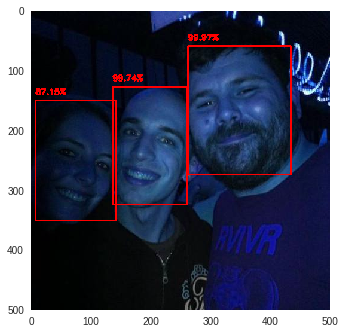

In [15]:
# show the output image
plt.imshow(image)
plt.grid(False)
plt.show()
#cv2.waitKey(0)

**Observations**

It is impressed that OpenCV can detect faces despite the lighting conditions and shadows cast on the face in the dark venue (and with 86.81% probability!)

Again, this just goes to show how much better (in terms of accuracy) the deep learning OpenCV face detectors are over their standard Haar cascade counterparts shipped with the library.

### Performing face detection in video using OpenCV and deep learning

In [0]:
#import necessary libraries
from imutils.video import FileVideoStream
from imutils.video import FPS
import imutils
import time

In [0]:
#Assign video to a variable
video = 'deep-learning-face-detection/Sony FS5 Face Detection Sample.mp4'

In [0]:
# load our serialized model from disk
net = cv2.dnn.readNetFromCaffe(prototxt, model)
 
# initialize the video stream and allow the camera sensor to warm up
vs = FileVideoStream(video).start()
time.sleep(1.0)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))

We initialize a VideoStream  object specifying camera with index zero as the source (in general this would be your laptop’s built in camera or your desktop’s first camera detected).

If you to parse a video file (rather than a video stream) swap out the VideoStream  class with FileVideoStream.

We then allow the camera sensor to warm up for 2 seconds.

From there, we loop over the frames and compute face detections with OpenCV:

In [0]:
# loop over the frames from the video stream
while vs.more():
  # grab the frame from the threaded video stream and resize it to have a maximum width of 400 pixels
  frame = vs.read()
  frame = imutils.resize(frame, width=400)
  
  # grab the frame dimensions and convert it to a blob
  (h, w) = frame.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  
  # pass the blob through the network and obtain the detections and predictions
  net.setInput(blob)
  detections = net.forward()
  
  # loop over the detections
  for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the prediction
    confidence_det = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the `confidence` is greater than the minimum confidence
    if confidence_det < confidence:
      continue
    
    # compute the (x, y)-coordinates of the bounding box for the object
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    
    # draw the bounding box of the face along with the associated probability
    text = "{:.2f}%".format(confidence * 100)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)
    cv2.putText(frame, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    out.write(frame)
    
  #show the output frame
  #plt.imshow(frame)
  #plt.grid(False)
  #plt.show()
  #key = cv2.waitKey(1) & 0xFF
  
  #if the `q` key was pressed, break from the loop
  #if key == ord("q"):
  #  break

In [0]:
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

### Reference

[https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/](https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/)